## Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using tf.keras.applications.EfficientNetB0 as the base model. Use the ModelCheckpoint callback to save the weights to file.

In [1]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [2]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [3]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [4]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_dir_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Building the model

In [12]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = base_model(inputs, training=False) # pass images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

# Summary of the model
model_2.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 12,810
Non-trainable params: 5,919,312
_________________________________________________________________


In [13]:
def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 10,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
    # Create base model
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    base_model.trainable = training

    inputs = layers.Input(shape=input_shape, name="input_shape")
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units=output_shape, activation = "softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])
    return model

model_2 = create_base_model()

In [14]:
# Setting up checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Creating a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq="epoch",
                                                         verbose=1)

In [16]:
initial_epoch = 10
history_10_percent_data = model_2.fit(train_dir_10_percent,
                                      epochs=initial_epoch,
                                      validation_data=test_data,
                                      validation_steps=int(0.25 * len(test_data)),
                                      callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data"),
                                                 checkpoint_callback])


Saving TensorBoard log files to: transfer_learning/10_percent_data/20240714-141222
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 1.8873 - accuracy: 0.4360
Epoch 1: val_loss improved from inf to 1.34159, saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 57s 680ms/step - loss: 1.8873 - accuracy: 0.4360 - val_loss: 1.3416 - val_accuracy: 0.7253
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 1.1094 - accuracy: 0.7920
Epoch 2: val_loss improved from 1.34159 to 0.90789, saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 8s 296ms/step - loss: 1.1094 - accuracy: 0.7920 - val_loss: 0.9079 - val_accuracy: 0.8191
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.7961 - accuracy: 0.8453
Epoch 3: val_loss improved from 0.90789 to 0.72446, saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [===

In [17]:
results_10_percent_data = model_2.evaluate(test_data)
results_10_percent_data

79/79 [==============================] - 10s 115ms/step - loss: 0.4474 - accuracy: 0.8712


[0.44739624857902527, 0.8712000250816345]

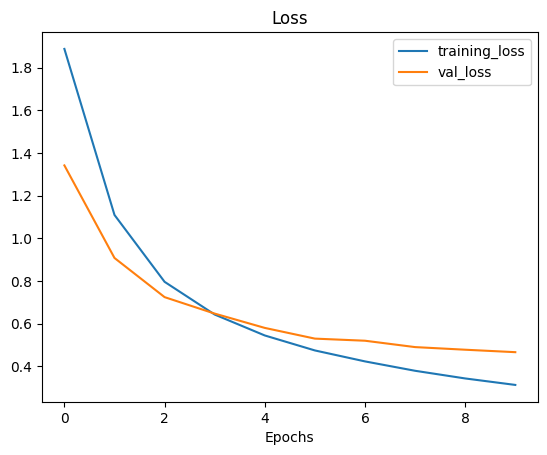

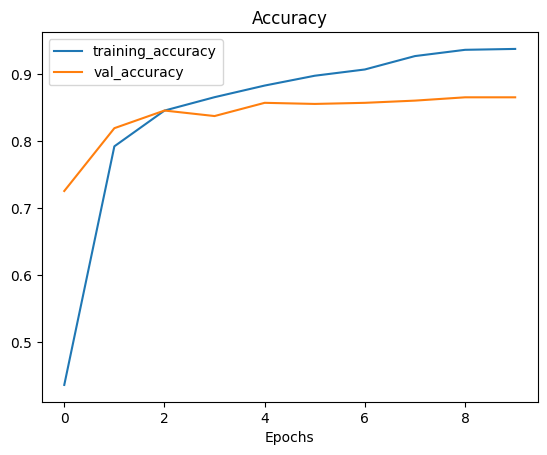

In [18]:
plot_loss_curves(history_10_percent_data)

## Hence we can conclude from the graphs that

As we have not implemented the data augmentation we can see overfitting. As the end tips of lines are spreading out

Checking the callback

In [20]:
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 9s 106ms/step - loss: 0.4474 - accuracy: 0.8712


In [21]:
results_10_percent_data == loaded_weights_model_results

True

## Fine-tune the last 20 layers of the base model you trained in for another 10 epochs. How did it go?


In [22]:
model_2.layers

In [23]:
for layer_number, layer in enumerate(model_2.layers):
    print(f"Layer number: {layer_number} | Layer name: {layer.name} | Layer type: {layer} | Trainable? {layer.trainable}")

Layer number: 0 | Layer name: input_shape | Layer type: <keras.engine.input_layer.InputLayer object at 0x000002A3787DF970> | Trainable? True
Layer number: 1 | Layer name: efficientnetv2-b0 | Layer type: <keras.engine.functional.Functional object at 0x000002A37E6857B0> | Trainable? False
Layer number: 2 | Layer name: global_average_pooling_layer | Layer type: <keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x000002A37E685300> | Trainable? True
Layer number: 3 | Layer name: output_layer | Layer type: <keras.layers.core.dense.Dense object at 0x000002A37E662740> | Trainable? True


In [25]:
model_2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_shape (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 12,810
Non-trainable params: 5,919,312
_________________________________________________________________


In [28]:
model_2_base_model = model_2.layers[1]
model_2_base_model.name

'efficientnetv2-b0'

In [29]:
# Checking how many layers are trainable
print(len(model_2_base_model.trainable_variables))

0


In [30]:
# Checking which layers are tunable
for layer_number, layer in enumerate(model_2_base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_8 False
1 rescaling_7 False
2 normalization_7 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [31]:
# Making all layers in model_2_base_model trainable
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-20]:
    layer.trainable = False

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])


In [32]:
# Checking the layers
for layer_number, layer in enumerate(model_2_base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_8 False
1 rescaling_7 False
2 normalization_7 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [33]:
print(len(model_2.trainable_variables))

18


In [34]:
fine_tune_epochs = initial_epoch + 10

# Refit the model
history_fine_10_percent_data = model_2.fit(train_dir_10_percent,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           initial_epoch=history_10_percent_data.epoch[-1],
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_20")])


Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_20/20240714-144016
Epoch 10/20
24/24 [==============================] - 22s 345ms/step - loss: 0.2561 - accuracy: 0.9320 - val_loss: 0.4035 - val_accuracy: 0.8569
Epoch 11/20
24/24 [==============================] - 5s 203ms/step - loss: 0.1706 - accuracy: 0.9573 - val_loss: 0.4216 - val_accuracy: 0.8602
Epoch 12/20
24/24 [==============================] - 5s 201ms/step - loss: 0.1266 - accuracy: 0.9707 - val_loss: 0.4390 - val_accuracy: 0.8438
Epoch 13/20
24/24 [==============================] - 5s 203ms/step - loss: 0.0912 - accuracy: 0.9840 - val_loss: 0.3957 - val_accuracy: 0.8717
Epoch 14/20
24/24 [==============================] - 5s 222ms/step - loss: 0.0633 - accuracy: 0.9867 - val_loss: 0.4563 - val_accuracy: 0.8635
Epoch 15/20
24/24 [==============================] - 6s 230ms/step - loss: 0.0433 - accuracy: 0.9960 - val_loss: 0.4655 - val_accuracy: 0.8635
Epoch 16/20
24/24 [==========================

In [35]:
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 9s 107ms/step - loss: 0.4805 - accuracy: 0.8748


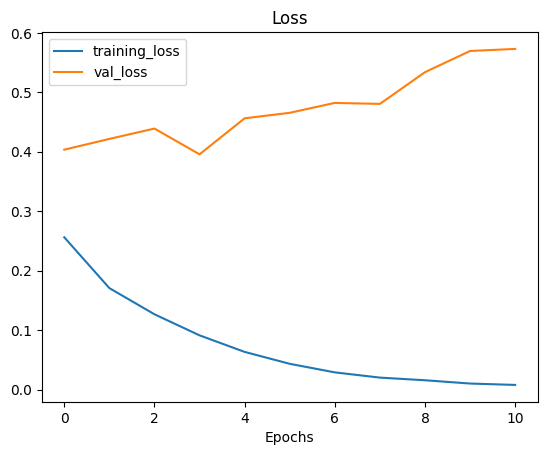

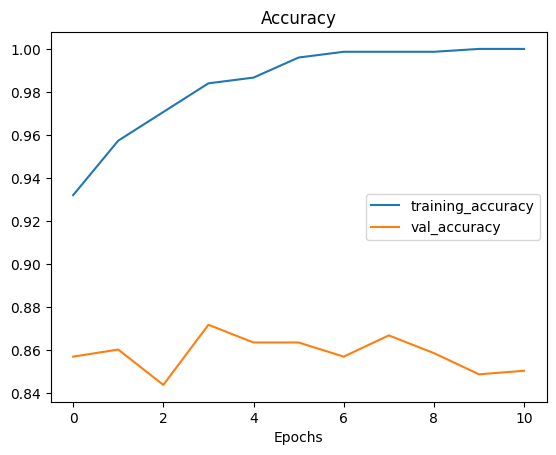

In [51]:
plot_loss_curves(history_fine_10_percent_data)

The Model works great but we are seeing overfitting because we haven't implemented data augmentation

In [37]:
import matplotlib.pyplot as plt

def compare_histories(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plot for accuracy
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Make plot for loss

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

10
21
[0.4359999895095825, 0.7919999957084656, 0.8453333377838135, 0.8653333187103271, 0.8826666474342346, 0.8973333239555359, 0.9066666960716248, 0.9266666769981384, 0.9359999895095825, 0.937333345413208, 0.9319999814033508, 0.9573333263397217, 0.9706666469573975, 0.984000027179718, 0.9866666793823242, 0.9959999918937683, 0.9986666440963745, 0.9986666440963745, 0.9986666440963745, 1.0, 1.0]


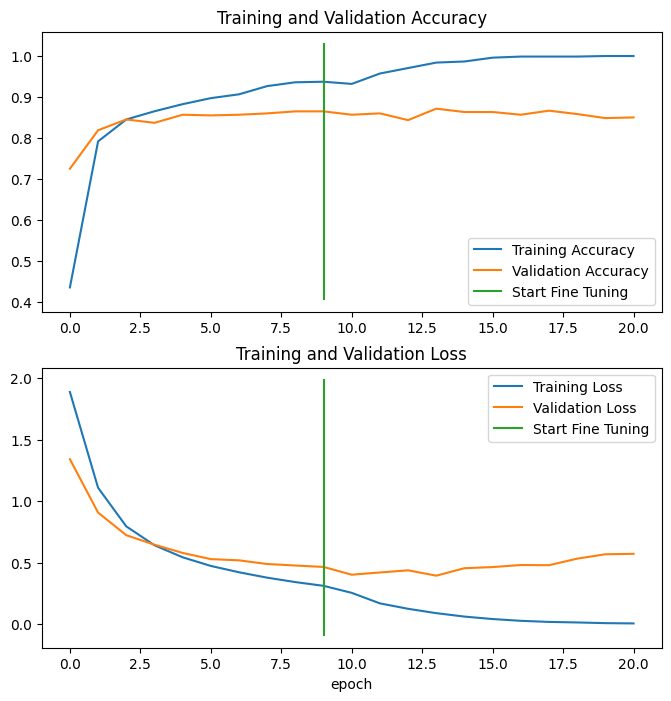

In [38]:
compare_histories(history_10_percent_data, history_fine_10_percent_data,
                  initial_epochs=10)

Overfitting becuase of non data augmentation

## Fine-tune the last 30 layers of the base model you trained in for another 10 epochs. How did it go?


In [44]:
model_2.layers

In [45]:
model_2_base_model = model_2.layers[1]
model_2_base_model.name

'efficientnetv2-b0'

In [46]:
# How many layers are trainable in our model_2_base_model
print(len(model_2_base_model.trainable_variables))

16


In [47]:
# Check which layers are tunable
for layer_number, layer in enumerate(model_2_base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_8 False
1 rescaling_7 False
2 normalization_7 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [48]:
# Make all layers in model_2_base_model trainable
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-30]:
    layer.trainable = False

# Recompile the whole model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [49]:
for layer_number, layer in enumerate(model_2_base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_8 False
1 rescaling_7 False
2 normalization_7 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [50]:
print(len(model_2.trainable_variables))

28


In [52]:
fine_tune_epochs_1 = fine_tune_epochs + 10

history_fine_10_percent_data_30_epoch = model_2.fit(train_dir_10_percent,
                                                    epochs=fine_tune_epochs_1,
                                                    validation_data=test_data,
                                                    initial_epoch=history_fine_10_percent_data.epoch[-1],
                                                    validation_steps=int(0.25 * len(test_data)),
                                                    callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_30")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_30/20240714-150417
Epoch 20/30
24/24 [==============================] - 22s 340ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.6117 - val_accuracy: 0.8635
Epoch 21/30
24/24 [==============================] - 5s 216ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.6723 - val_accuracy: 0.8454
Epoch 22/30
24/24 [==============================] - 5s 219ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.6612 - val_accuracy: 0.8651
Epoch 23/30
24/24 [==============================] - 5s 217ms/step - loss: 8.8120e-04 - accuracy: 1.0000 - val_loss: 0.6560 - val_accuracy: 0.8651
Epoch 24/30
24/24 [==============================] - 5s 216ms/step - loss: 5.7988e-04 - accuracy: 1.0000 - val_loss: 0.6107 - val_accuracy: 0.8734
Epoch 25/30
24/24 [==============================] - 5s 216ms/step - loss: 4.3736e-04 - accuracy: 1.0000 - val_loss: 0.6705 - val_accuracy: 0.8618
Epoch 26/30
24/24 [==============

In [53]:
results_fine_tune_10_percent_30_epochs = model_2.evaluate(test_data)

79/79 [==============================] - 9s 106ms/step - loss: 0.6388 - accuracy: 0.8732


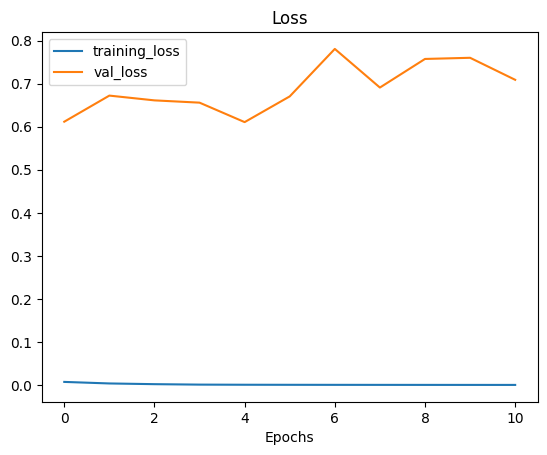

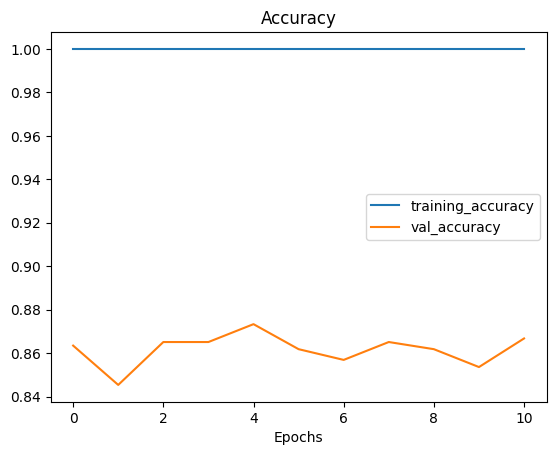

In [54]:
plot_loss_curves(history_fine_10_percent_data_30_epoch)

## Ulta pro max over fitting

In [57]:
import matplotlib.pyplot as plt

def compare_histories(original_history, new_history, another_history, initial_epochs=5, second_epochs=10):
    """
    Compares three model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]
    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]
    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Combine the combined history with another history
    total_acc += another_history.history["accuracy"]
    total_loss += another_history.history["loss"]
    total_val_acc += another_history.history["val_accuracy"]
    total_val_loss += another_history.history["val_loss"]

    # Print lengths for verification
    print(f"Length of total accuracy history: {len(total_acc)}")
    print(f"Length of total loss history: {len(total_loss)}")

    # Make plot for accuracy
    plt.figure(figsize=(10, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.axvline(x=initial_epochs-1, color='r', linestyle='--', label='Start Fine Tuning')
    plt.axvline(x=initial_epochs + second_epochs-1, color='g', linestyle='--', label='Start Another Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Make plot for loss
    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.axvline(x=initial_epochs-1, color='r', linestyle='--', label='Start Fine Tuning')
    plt.axvline(x=initial_epochs + second_epochs-1, color='g', linestyle='--', label='Start Another Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.show()

# Example usage (assuming histories are available)
# compare_histories(history1, history2, history3, initial_epochs=5, second_epochs=10)


Length of total accuracy history: 32
Length of total loss history: 32


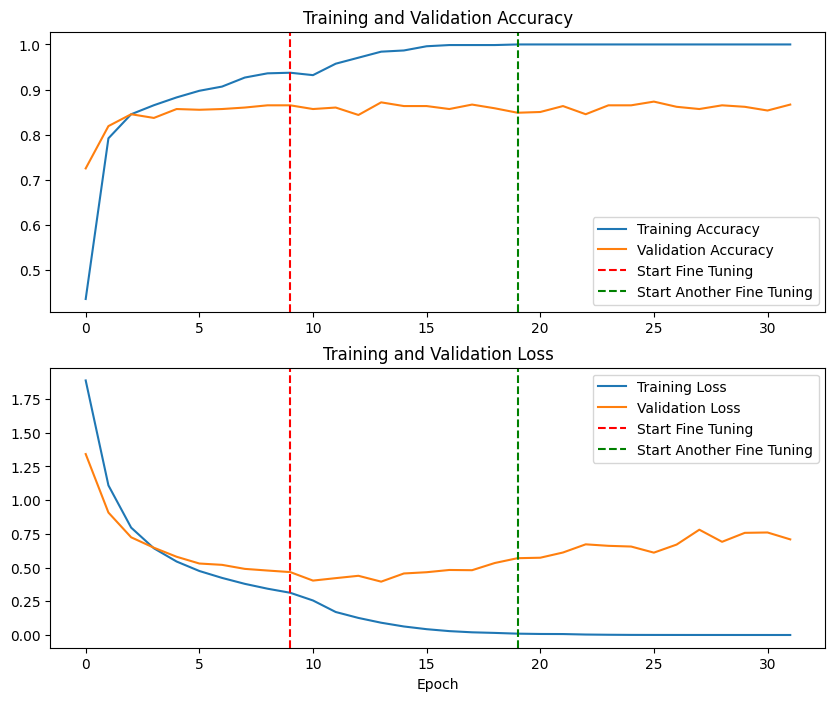

In [58]:
compare_histories(history_10_percent_data, history_fine_10_percent_data, history_fine_10_percent_data_30_epoch, initial_epochs=10)